In [1]:
"""
This notebook performs the following tasks:
1) Read a few millions of network metrics collected from many network endpoints.
2) Use SPARK ML K-Mean algorithm to cluster selected columns of the metrics into 
   K groups. (K = 99,999) Each group will be viewed as a "network performance
   profile". 
3) Train an ALS model as a network recommender system through 'model selection'. 
   The trained model will be used to recommend better network configurations for
   network endpoints. 
   
   Two model selection methods are available:
   A) SPARK CrossValidator class with a 2D parameter grid 
      (https://spark.apache.org/docs/latest/ml-tuning.html)
   B) my Heuristic Interleaved Parameter Alternator (HIPA)
   
   During tests, HIPA can save 80-90% iterations and achieve similar accuracy.
   That is x5-x10 faster than using SPARK CrossValidator.

4) Evaluate the selected (best) model based on RMSE or MAE.
"""
import numpy as np
import shutil

spark_sql = SQLContext(sc)

In [2]:
%%time
# Wall time: 11.6 s (etl2M.csv has 2,374,992 rows)

''' 
read data
'''
df_orig = spark_sql.read.format('com.databricks.spark.csv')\
    .options(header='false', inferschema='true')\
    .load('../data/etl2M.csv' if os.path.isfile('../data/etl2M.csv') else '../data/etl2M.csv.*')

'''
Use VectorAssembler to assembly interesting columns as the "features" for K-Mean clustering.
ALS algorithm also needs this "features" column to act as the "user characteristic". 
The column actually contains "latent factors" of a network "performance profile" which contain
not only status of network endpoints at a minute but also implies possible 'reconfiguration'
or 'actions' that can be applied by an endpoint in order to achieve the performance. 
'''
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=["_c1","_c3", "_c6", "_c9", "_c12", "_c15", "_c18"],
    outputCol="features")
df_features = assembler.transform(df_orig)

# this dataframe will be fit to K-Mean below
df_features.cache()

CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 7.95 s


In [3]:
%%time

'''
Train a K-Means model using df_feature, if not trained yet.
!! SPARK KMeans is much slower than Intel DAAL's Kmeans...
'''
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.clustering import KMeans

'''
How to pick a good 'K' value? We can use 'model selection' to find
better K values, like how we'll do for ALS model selection. However,
the ranges of possible (good) K values can be vast while Kmean model
training on each of the possible K values can take quite some hours. 
That would total up to weeks or even months to learn better K values.

Instead, here we pick a K value based on our possible ranges of each
input column of VectorAssembler in previous cell. For example, assume
valid _c1 values are in the range of [-90, -20], we can partition the 
range to 20 segments, each of which may exhibit similar impact on 
network performance. With similar partitioning being applied to the 
other input columns, we can multiply the number of segments of
each partition column and it may come out with possible good K values
in the range from hundreds of thousands to millions, each of which can
have SPARK KMean spin its head for many many hours. So, for sake of 
energy conservation with reasonable accurcy, let's test the water in 
the lower order. Of course, we won't know how accurate the '100K' clusters
will be until we apply them to our ALS Recommender model and data set.
'''
K=99999

# train Kmean only if not yet, because it'll take many hours.
path_to_save_model = "/data/tmp/spark/KMeansModel-ml"
if os.path.isdir(path_to_save_model):
    model = KMeansModel.load(path_to_save_model)
else:
    kmeans = KMeans(initMode="random").setK(K).setSeed(1)
    model = kmeans.fit(df_features)
    shutil.rmtree(path_to_save_model, ignore_errors=True) 
    model.save(path_to_save_model)


CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 1.27 s


In [4]:
%%time
# Wall time: 222 ms (k=9999)

'''
Transform all samples to learn their groups. Each group 
corresponds to a network 'profile' (in a form of their indexes)
'''
df_clustered = model.transform(df_features)
df_clustered.show()

+----+---+-----+---+---+----+---+---+----+---+----+----+----+----+----+----+----+----+----+----+--------------------+----------+
| _c0|_c1|  _c2|_c3|_c4| _c5|_c6|_c7| _c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|            features|prediction|
+----+---+-----+---+---+----+---+---+----+---+----+----+----+----+----+----+----+----+----+----+--------------------+----------+
|5358|  1|-40.0|-40|  0|44.0| 44| -1|46.0| 47|   1| 0.0|   0|  -1| 1.0|   1|   0|94.0|  88| -12|[1.0,-40.0,44.0,4...|      2559|
|5294|  1|-59.0|-59| 12|94.0| 97|  2| 1.0|  1|   0| 1.0|   1|   0| 2.0|   3|   0|65.0|  90|  50|[1.0,-59.0,97.0,1...|       663|
|5295|  0|-50.0|-47|  6|74.0| 73|  0| 0.0|  0|   0| 0.0|   0|   0| 1.0|   1|   0|83.0| 100|  46|[0.0,-47.0,73.0,0...|      7146|
|5290|  0|-26.0|-24|  1|74.0| 77|  0| 0.0|  0|   0| 0.0|   0|   0| 1.0|   1|   0|55.0|  50|  25|[0.0,-24.0,77.0,0...|      4408|
|5290|  0|-26.0|-26| -2|74.0| 67|-10| 0.0|  0|   0| 0.0|   0|   0| 1.0|   1|   0|55.0|  25| -25|[

In [5]:
'''
From K-Mean result, extract '_c0', '_c18' and 'prediction' columns. 

Those columns actually have the following semantic meaning and mappings:
     _c0       : network enpoint id             <==> 'user'   part for ALS recommender
     prediction: network profile number         <==> 'item'   part for ALS recommender
     _c18      : effective network throughput   <==> 'rating' part for ALS recommender
'''

df_merged = df_clustered.select('_c0', '_c18', 'prediction')
df_merged.show()

+----+----+----------+
| _c0|_c18|prediction|
+----+----+----------+
|5358|  88|      2559|
|5294|  90|       663|
|5295| 100|      7146|
|5290|  50|      4408|
|5290|  25|      6041|
|5290|  75|      5551|
|5290|  75|      3951|
|5290| 100|      5667|
|5294|  80|      4544|
|5361|  44|      3936|
|5295|  90|      4891|
|5361|  80|       457|
|5361|  66|      8336|
|5295|  90|      5239|
|4989|  90|       522|
|5191|  80|      5365|
|5295|  90|      5239|
|5361|  66|       753|
|5191|  90|      6506|
|4989| 100|      7416|
+----+----+----------+
only showing top 20 rows



In [7]:
%%time
# Wall time: 1min (k=99,999)

'''
Aggregate (_c0, _c18, prediction) rows to UNIQUE rows (= endpoint, profile, rating).
The rows will become the training/testing data of our ALS model below.
'''
df_merged.createOrReplaceTempView("merged")
df_ratings = spark_sql.sql('''
    SELECT _c0 as sta, prediction as profile, avg(_c18) as phyr
    FROM merged
    GROUP BY _c0, prediction
    ''')
# df_ratings.explain()
df_ratings.show()

+----+-------+-----+
| sta|profile| phyr|
+----+-------+-----+
|4718|   3755| 72.0|
|4700|   2595| 27.0|
|4566|   6003| 67.0|
|4248|   8372| 59.0|
|4597|   6165| 44.0|
|4129|   6495|100.0|
|4356|   1905|100.0|
|4356|   7291| 81.0|
|5194|   4858| 80.0|
|4262|   7627| 66.0|
|4180|   3787| 81.0|
|4409|   8502| 29.5|
|4734|   6093| 90.0|
|4028|   1106|100.0|
|4359|   3731| 19.6|
|4156|   1314| 30.0|
|4516|   8474|100.0|
|4160|   5755| 47.0|
|4144|   3060| 90.0|
|4387|    320|100.0|
+----+-------+-----+
only showing top 20 rows

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 1min 25s


In [8]:
%%time
# Wall time: 17min 57s (2m rows)

# split df_ratings to training and test sets
(training, test) = df_ratings.randomSplit([0.95, 0.05])

'''
Another data cleanse is needed here, because SPARK ML default 'cold start'
strategy is 'nan' which is problematic at cross verification stage. This cleanse 
is to make sure all endpoints and profiles in test set are also in training set, 
else ML evaluator returns 'NaN' when predict on unknown STA or profile
'''
coldStartStrategy="drop"   # set to drop so no cleanse is ok for SPARK ML cold start
if coldStartStrategy != 'drop':
    stas = {}
    profiles = {}

    # collect all STAs and profiles that are in training set.
    for x in training.rdd.collect():
        if x.sta not in stas:
            stas[x.sta] = True
        if x.profile not in profiles:
            profiles[x.profile] = True
    print training.count()

    # collect STAs and profiles that are in test data set but 
    # not in training data set to a 'patch data set'
    patch = []
    for x in test.rdd.collect():
        if x.sta not in stas or x.profile not in profiles:
            patch.append(x)

    # add the patch data set to training data set
    print len(patch)
    training = training.union(sc.parallelize(patch).toDF())
    print training.count()

training.cache()
test.cache()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 200 ms


In [9]:
%%time
# Wall time: 27h 1min 21s (2M rows !!!)

'''
Use Spark ML CrossValidator for "Model selection" and build an ALS model. 

* This is deprecated, as CrossValidator iterates ALL combinations 
* of hyper-parameters so it takes lots of time compared with using HIPA.
'''
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Skipped. Use my own 'HIPA' method due to CrossValidator performance issue. 
# Also, RegressionEvaluator.isBiggerBetter() is supported only in SPARK 2.2+
if False:
    als = ALS(maxIter=10, 
              userCol="sta", itemCol="profile", ratingCol="phyr", 
              implicitPrefs=False, coldStartStrategy = coldStartStrategy)
    paramGrid = ParamGridBuilder()\
        .addGrid(als.rank, range(7, 10, 1))\
        .addGrid(als.regParam, np.arange(0.1, 2.0, 0.5))\
        .build()

    evaluator_mae  = RegressionEvaluator(metricName="mae",  labelCol="phyr", predictionCol="prediction")
    evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="phyr", predictionCol="prediction")

    # !!! Somehow CrossValidator always returns the first set on the parameter grid.
    # !!! Checked RegressionEvaluator.isLargerBetter(). It is False. Why does it fail...???
    # *** Checked SPARK versions and found RegressionEvaluator.isLargerBetter() is only in v2.2.0+.
    crossValidator = CrossValidator(
        estimator=als,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator_mae,  # use mae for now
        numFolds=5)

    # run cross-validation, and choose the best set of parameters.
    cvModel = crossValidator.fit(training)
    print "RegressionEvaluator(mae) =", evaluator_mae.isLargerBetter()

    # test the model with the best parameters
    predictions = cvModel.transform(test)

    # Evaluate the model by computing the MAE on the test data
    print "Mean-average error = %.4f"     % evaluator_mae .evaluate(predictions)
    print "Root-mean-square error = %.4f" % evaluator_rmse.evaluate(predictions)

    # know best rank/reg
    print "best rank = %d" % cvModel.bestModel.rank
    print "best reg = %.1f" % cvModel.bestModel._java_obj.parent().getRegParam()

    plot_chart(test, predictions, 'spark_kmean_9999_als_2m_CrossValidator')

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 8.72 ms


In [17]:
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

'''
Plot only the first nc samples, because squeezing all samples on a 
chart makes it look messy so not a good data visualization approach.
'''
def plot_chart(predictions, title, nc=0, sorty=True):
    if nc == 0: 
        nc = predictions.count()

    truths   = predictions.select("phyr").head(nc)
    predicts = predictions.select("prediction").head(nc)
    
    # sort the two lists "synchronously" based one to avoid a fluctuating look
    if sorty:
        truths, predicts = zip(*sorted(zip(truths, predicts)))

    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    
    plt.scatter(np.arange(0,len(predicts)), predicts, c='r', s=2, label='prediction')
    plt.scatter(np.arange(0,len(truths)),   truths,   c='b', s=2, label='ground truth')
    plt.axis('tight')
    plt.legend()
    plt.title(title)
    plt.savefig("/data/tmp/%s.png" % title)
    plt.grid()
    plt.show()
    plt.clf()

In [28]:
%%time

'''
Only in SPARK 2.2.0+ can CrossValidator support RegressionEvaluator.isLargerBetter()
Even CrossValidator works, it took almost days to iterate thru entire parameter grid.
My 'HIPA' method seems to work much faster and equally good on accuracy.
'''
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
import sys

nhit = 0
maes = {}
rmses = {}
best_model = ''
min_error = sys.float_info.max

def hipa_key(rank, reg, maxIter=1):
    return '%2d, %.2f, %2d' % (rank, reg, maxIter)

def hipa_fit(rank, reg, maxIter=1):
    als = ALS(maxIter=maxIter, rank=rank, regParam=reg, 
            userCol="sta", itemCol="profile", ratingCol="phyr",
            implicitPrefs=False, coldStartStrategy=coldStartStrategy)
    model = als.fit(training)
    return model

def hipa_err(mae, rmse, basedOn='rmse'):
    return mae if basedOn == 'mae' else rmse;

def hipa_estimate(rank, reg, maxIter=1, basedOn='rmse'):
    # check cached errs to avoid re-calc 
    key = hipa_key(rank, reg, maxIter);
    if key in maes:
        return key, hipa_err(maes[key], rmses[key], basedOn), True

    # fit and test model with this parameter tuple
    model = hipa_fit(rank, reg, maxIter)
    predictions = model.transform(test)
    
    # eval errs
    mae  = RegressionEvaluator(metricName="mae",  labelCol="phyr", predictionCol="prediction").evaluate(predictions)
    rmse = RegressionEvaluator(metricName="rmse", labelCol="phyr", predictionCol="prediction").evaluate(predictions)
    
    # cache for later sort to top 10 sets of parameters
    maes [key] = mae
    rmses[key] = rmse

    # save best model so that no need to re-fit after cross validations
    global min_error
    global best_model
    if (basedOn == 'mae'  and mae  < min_error) \
    or (basedOn == 'rmse' and rmse < min_error):
        min_error = mae if basedOn == 'mae' else rmse;
        best_model = model
    
    return key, hipa_err(mae, rmse, basedOn), False


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 520 µs


In [67]:
%%time

# Depending on size of data set, this cell can take many minutes to hours. 
# It often times out the session and becomes offline, so %%time can't help
import time
tstart = time.time()

'''
 Heuristic Interleaved Parameter Alternator (HIPA):
 
 The basics of the idea is find the best parameter set by iterating 
 a large subrange of only one parameter at a time while visiting only 
 few pivot values of all other parameters in (ranks, reg, alpha, lambda) 
 tuples. The pivot values of a parameter are selected among those which
 have the (topmost 2 or 3) minimum RMSE errors from model training.
 
 In contrast, SPARK ML CrossValidator iterates all tuples of in a 
 parameter grid, so it takes much more iterations.
 
 Can we optimize model selection use Stochastic Gradient Descent like in 
 neural network or deep learning? IMO, it's hard if not can't. Values in 
 parameter grids are normally discrete, so it's not relevant to apply a
 continuous function like derivative on the parameters.
'''
# implicit ALS needs 4 parameters: rank, alpha, lambda and iterations (ref. DAAL C++)
# explicit ALS needs 3 parameters: rank, regulation and iterations
ranks = np.arange(  20,  61,    1)
regus = np.arange( 0.1, 2.1,  0.1)   # must not zero!!
iters = np.arange(   5,  11,    1)   # max iteration
pms   = [ranks, regus, iters]        # order is significant
NP    = len(pms)

pmsiz = [len(pms[i]) //  1 for i in range(NP)]
print 'pmsiz = %s' % str(pmsiz)

pidxs = [[0, pmsiz[i]//2, pmsiz[i]-1] for i in range(NP)]

# emin[p][i] stores minimum rmse so far calculated on pms[p][i]
# top NTOP indices will be preferred after intv[p] = 1 pass
# !!! emin = [{}] * NP shares {} among all parameters 1!!
emin = [{} for i in range(NP)]

# this dict is to track total calcs regardless if rmses cache
# is propagated from prior call run or not.
calc = {}
ncalc = 0

nhit = 0
fullp = 0
full = [False] * NP
min_rmse = sys.float_info.max
nstall = 0
NTOP = 2
while True:
    # collect indices of all parameters to try in this round
    niter = 1
    for p in range(NP):
        # sort dict emin[p] by value. 
        ekvs = sorted(emin[p].iteritems(), key=lambda (k,v): (v,k))
        if p == fullp:
            if not full[p]:
                pidxs[p] = range(pmsiz[p])
                full[p] = True
            else:
                weaks = dict(ekvs[NTOP:])
                pidxs[p] = []
                for i in range(pmsiz[p]):
                    if i not in weaks: pidxs[p].append(i)
        elif emin[p]:
            pidxs[p] = list(map(lambda (k,v): k, ekvs[0:NTOP]))
        
        pvals = [pms[p][i] for i in pidxs[p]]
        print 'pidxs[%d]=%d=%s ' % (p, len(pidxs[p]), str(pvals))
        # product of all index lengths
        niter *= len(pidxs[p])

    new_min = False
    for it in range(niter):
        pidx = [0] * NP
        # update locally all parameters of this run
        # by breaking down current 'it' value
        tit = it
        for p in range(NP):
            pidx[p] = pidxs[p][tit % len(pidxs[p])]
            tit = int(tit / len(pidxs[p]))

        key, rmse, hit = hipa_estimate(ranks[pidx[0]], 
                                       regus[pidx[1]], 
                             maxIter = iters[pidx[2]])
        if hit: nhit += 1
        
        # debug out of bound index
        sidx = str(pidx)
        print("%20s rmse(%s) = %.5f %s %s" % 
              (sidx, key, rmse, ('-' if hit else ''), ('*' if min_rmse > rmse else '')))

        if  min_rmse > rmse:
            min_rmse = rmse
            new_min = True

        # track min/avg rmse of all indexes of all parameters
        # this is to avoid revisit "weak" values on 2nd round
        for p in range(NP):
            i = pidx[p]
            emin[p][i] = min(emin[p][i], rmse) if i in emin[p] else rmse

        # this correctly counts calcs in case rmses cache is propagated.
        # cache is propagated only in development and not in production.
        if key not in calc: ncalc += 1
        calc[key] = True
        
    fullp = (fullp + 1) % NP
    nstall = 0 if new_min else nstall+1

    # stop when no parameter improved and all parameters
    # have been tried in the finest granularity
    if nstall >= 1 * NP:  # full scans each param
        break

tend = time.time()
# see next cell for print(end - start)

pmsiz = [41, 20, 6]
pidxs[0]=41=[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60] 
pidxs[1]=3=[0.10000000000000001, 1.1000000000000001, 2.0] 
pidxs[2]=3=[5, 8, 10] 
           [0, 0, 0] rmse(20, 0.10,  5) = 6.33535  *
           [1, 0, 0] rmse(21, 0.10,  5) = 5.50039  *
           [2, 0, 0] rmse(22, 0.10,  5) = 5.27206  *
           [3, 0, 0] rmse(23, 0.10,  5) = 5.26172  *
           [4, 0, 0] rmse(24, 0.10,  5) = 5.35081  
           [5, 0, 0] rmse(25, 0.10,  5) = 5.52540  
           [6, 0, 0] rmse(26, 0.10,  5) = 5.75163  
           [7, 0, 0] rmse(27, 0.10,  5) = 5.46309  
           [8, 0, 0] rmse(28, 0.10,  5) = 6.00514  
           [9, 0, 0] rmse(29, 0.10,  5) = 6.56530  
          [10, 0, 0] rmse(30, 0.10,  5) = 5.94483  
          [11, 0, 0] rmse(31, 0.10,  5) = 6.48453  
          [12, 0, 0] rmse(32, 0.10,  5) = 6.12759  
          [13, 0, 0] rmse(33, 0.10,  5) 

          [31, 0, 3] rmse(51, 0.10,  8) = 5.79567  
          [32, 0, 3] rmse(52, 0.10,  8) = 5.62208  
          [33, 0, 3] rmse(53, 0.10,  8) = 6.37406  
          [34, 0, 3] rmse(54, 0.10,  8) = 6.41717  
          [35, 0, 3] rmse(55, 0.10,  8) = 6.04565  
          [36, 0, 3] rmse(56, 0.10,  8) = 6.14883  
          [37, 0, 3] rmse(57, 0.10,  8) = 6.53559  
          [38, 0, 3] rmse(58, 0.10,  8) = 6.33967  
          [39, 0, 3] rmse(59, 0.10,  8) = 6.53642  
          [40, 0, 3] rmse(60, 0.10,  8) = 5.67279  
          [0, 10, 3] rmse(20, 1.10,  8) = 3.27105 - *
          [1, 10, 3] rmse(21, 1.10,  8) = 2.93696 - *
          [2, 10, 3] rmse(22, 1.10,  8) = 2.94221 - 
          [3, 10, 3] rmse(23, 1.10,  8) = 2.99566 - 
          [4, 10, 3] rmse(24, 1.10,  8) = 2.82346 - *
          [5, 10, 3] rmse(25, 1.10,  8) = 2.78330 - *
          [6, 10, 3] rmse(26, 1.10,  8) = 2.86711 - 
          [7, 10, 3] rmse(27, 1.10,  8) = 3.05688 - 
          [8, 10, 3] rmse(28, 1.10,  8) = 3.07389 - 

         [31, 10, 5] rmse(51, 1.10, 10) = 2.83356  
         [32, 10, 5] rmse(52, 1.10, 10) = 2.87816  
         [33, 10, 5] rmse(53, 1.10, 10) = 2.95309  
         [34, 10, 5] rmse(54, 1.10, 10) = 2.91015  
         [35, 10, 5] rmse(55, 1.10, 10) = 2.89926  
         [36, 10, 5] rmse(56, 1.10, 10) = 2.91445  
         [37, 10, 5] rmse(57, 1.10, 10) = 2.99405  
         [38, 10, 5] rmse(58, 1.10, 10) = 2.99295  
         [39, 10, 5] rmse(59, 1.10, 10) = 2.97594  
         [40, 10, 5] rmse(60, 1.10, 10) = 2.88275  
          [0, 19, 5] rmse(20, 2.00, 10) = 3.81660  
          [1, 19, 5] rmse(21, 2.00, 10) = 3.83084  
          [2, 19, 5] rmse(22, 2.00, 10) = 3.87027  
          [3, 19, 5] rmse(23, 2.00, 10) = 3.82392  
          [4, 19, 5] rmse(24, 2.00, 10) = 3.79279  
          [5, 19, 5] rmse(25, 2.00, 10) = 3.89639  
          [6, 19, 5] rmse(26, 2.00, 10) = 3.87480  
          [7, 19, 5] rmse(27, 2.00, 10) = 3.92068  
          [8, 19, 5] rmse(28, 2.00, 10) = 3.86510  
          [9

In [73]:
'''
Print HIPA summary and top 10 best models.
About 80-90% trainings were saved per different parameter grids.
RMSE is ~ 2. (ratio is 2% of the maximum value 100)
'''
tsec = tend - tstart
tmin = tsec // 60
tsec = tsec %  60
thrs = tmin // 60
tmin = tmin %  60
tuse = '%d:%d:%d' % (thrs, tmin, tsec)

ocalc = reduce(lambda x,y: x*y, pmsiz)  
print 'time used     : %s' % tuse
print 'calcs w/o hipa: %d' % ocalc 
print 'calcs w/  hipa: %d' % ncalc 
print 'calc hits     : %d' % nhit 
print 'calc saving   : %d%%' % int(100.0 * (ocalc - ncalc) / ocalc) 
print 
print 'top 10 best parameter sets:'

import operator 
errors = sorted(rmses.items(), key=operator.itemgetter(1))[:10] 
for i, e in enumerate(errors): 
    rank, regu, iter = e[0].split(', ') 
    print '%d: rmse %.5f, rank %3s, regu %s, iter %s' % (i, e[1], rank, regu, iter)

time used     : 1:5:7
calcs w/o hipa: 4920
calcs w/  hipa: 453
calc hits     : 590
calc saving   : 90%

top 10 best parameter sets:
0: rmse 2.17300, rank  17, regu 0.70, iter 10
1: rmse 2.18141, rank  17, regu 0.60, iter 10
2: rmse 2.18602, rank  25, regu 0.60, iter 10
3: rmse 2.19432, rank  25, regu 0.70, iter 10
4: rmse 2.20672, rank  17, regu 0.80, iter 10
5: rmse 2.24223, rank  17, regu 0.50, iter 10
6: rmse 2.24932, rank  24, regu 0.70, iter 10
7: rmse 2.25034, rank  25, regu 0.80, iter 10
8: rmse 2.25561, rank  24, regu 0.60, iter 10
9: rmse 2.25603, rank  25, regu 0.50, iter 10


In [72]:
# show the best parameters
mkey = errors[0][0]
print "best rank, reg, iter = %s" % mkey
print "min_mae [%s] = %f" % (mkey, maes [mkey])
print "min_rmse[%s] = %f" % (mkey, rmses[mkey])


best rank, reg, iter = 17, 0.70, 10
min_mae [17, 0.70, 10] = 1.040252
min_rmse[17, 0.70, 10] = 2.173003


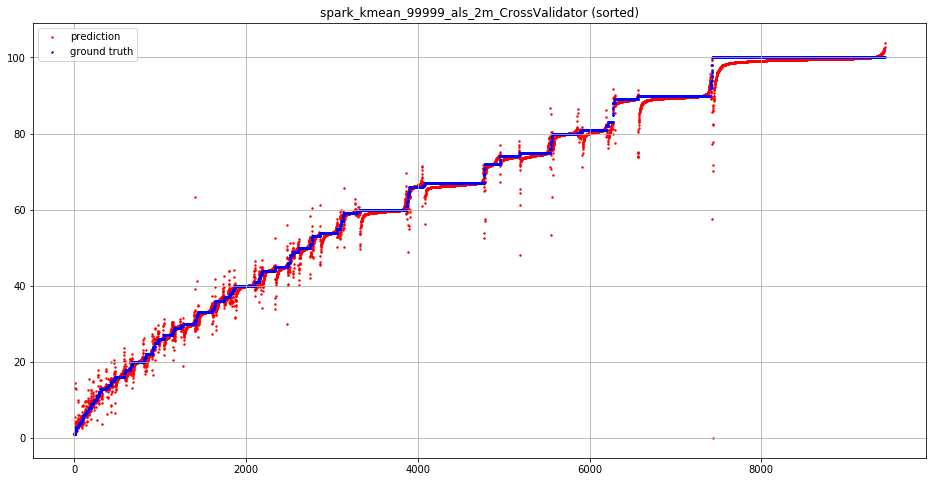

CPU times: user 960 ms, sys: 1.75 s, total: 2.71 s
Wall time: 19.2 s


In [70]:
%%time
# Wall time: 19.2 s

# use test data set to verify the best learned model
predictions = best_model.transform(test)

# (entertain myself) verify spark's rmse using my own calculator
if False:
    import math
    rdds = predictions.rdd.map(lambda x: ((x.phyr - x.prediction)*(x.phyr - x.prediction), (x.phyr)*(x.phyr)))
    deltas = rdds.map(lambda x: x[0]).reduce(lambda x,y: x+y)
    imprvs = rdds.map(lambda x: x[1]).reduce(lambda x,y: x+y)
    print 'deltas = %f' % deltas
    print 'rdds.count = %d' % rdds.count()
    print 'rmse = %f' % (math.sqrt(deltas/rdds.count()))

# plot the predictions
plot_chart(predictions, 'spark_kmean_%d_als_2m_CrossValidator (sorted)' % K)    

In [58]:
%%time

# recommend 10 profiles for everyone
rcmd_profiles = best_model.recommendForAllUsers(10)
rcmd_profiles.show()

+----+--------------------+
| sta|     recommendations|
+----+--------------------+
|5300|[[8243,100.15496]...|
|1342|[[1085,110.37859]...|
|2122|[[1085,105.65619]...|
|2142|[[8243,102.00564]...|
|2366|[[4609,107.671814...|
|1959|[[1085,101.342674...|
|3749|[[8243,102.77281]...|
|4519|[[1085,106.31731]...|
|1721|[[1085,108.06614]...|
|4161|[[8243,101.478165...|
|3475|[[1085,106.63253]...|
|3698|[[1085,105.278175...|
|4158|[[169,100.6832], ...|
|2999|[[4422,99.64819],...|
|3179|[[7497,106.141846...|
|1650|[[1085,106.165245...|
|3000|[[1085,106.07077]...|
|4391|[[1085,107.89579]...|
|1322|[[1085,107.46966]...|
|1352|[[8243,100.0453],...|
+----+--------------------+
only showing top 20 rows

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 5.38 s


In [59]:
# peek recommended profiles and rating (network throughput) of a endpoint
profiles = rcmd_profiles.where('sta == 5300').select('recommendations.profile').collect()
ratings  = rcmd_profiles.where('sta == 5300').select('recommendations.rating').collect()

In [64]:
pair = zip(profiles[0]['profile'], ratings[0]['rating'])

# from __future__ import print_function
# map(lambda (x, y):print(x, ' - ', y), pair)

In [61]:
pair

[(8243, 100.15496063232422),
 (3263, 99.41224670410156),
 (2762, 99.3109359741211),
 (5591, 99.1719970703125),
 (169, 99.09192657470703),
 (5326, 99.00418853759766),
 (7438, 98.9896011352539),
 (4974, 98.97924041748047),
 (526, 98.97040557861328),
 (6914, 98.94583129882812)]

In [ ]:
best_model.userFactors.collect()

In [ ]:
best_model.itemFactors.collect()

In [66]:
%%time 

# Let's recommend the best 10 network profiles for a specific endpoint (id = 3000)

# Pro:
#     The model recommends 10 best performance profiles that can
#     even achieve >100% theoretic PHY rate of the endpoint.
# Con:
#     It took 5+ secs! Such a response time seems not good for real-time 
#     prediction in production environment. We may need massive GPU for 
#     a prediction workload of millions of network endpoints when even a small
#     percentage (say 1%) of them may roam and need dynamic steering.
testdata_1u = spark_sql.createDataFrame([(3000,p,0) for p in range(K)],['sta', 'profile', 'phyr'])
predictions_1u = best_model.transform(testdata_1u)
predictions_1u.where('isNaN(prediction) = FALSE')\
    .orderBy('prediction', ascending=False)\
    .limit(10)\
    .show()

+----+-------+----+----------+
| sta|profile|phyr|prediction|
+----+-------+----+----------+
|3000|   1085|   0| 106.07077|
|3000|   1504|   0| 102.09174|
|3000|   8112|   0|101.349594|
|3000|    402|   0| 101.34347|
|3000|   1476|   0| 101.33288|
|3000|   3768|   0| 101.31005|
|3000|    117|   0| 101.29764|
|3000|    463|   0| 101.29527|
|3000|   5286|   0| 101.22453|
|3000|   6285|   0| 101.09802|
+----+-------+----+----------+

CPU times: user 3.1 s, sys: 0 ns, total: 3.1 s
Wall time: 6 s
